# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
import seaborn as sns

In [2]:
pd.options.display.max_columns = 25
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,False,False,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


In [3]:
data.info()

#first_day_exposition перевести в дату, чтоб в дальнейшем понять в какие месяца была основная часть сделок
#floors_total  перевести в int
#is_apartment должно быть булевое значение, проверить почему object
#balcony в int
#days_exposition перевести в int
# проверить, почему имеются пропуски и заменить их на данные или удалить


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

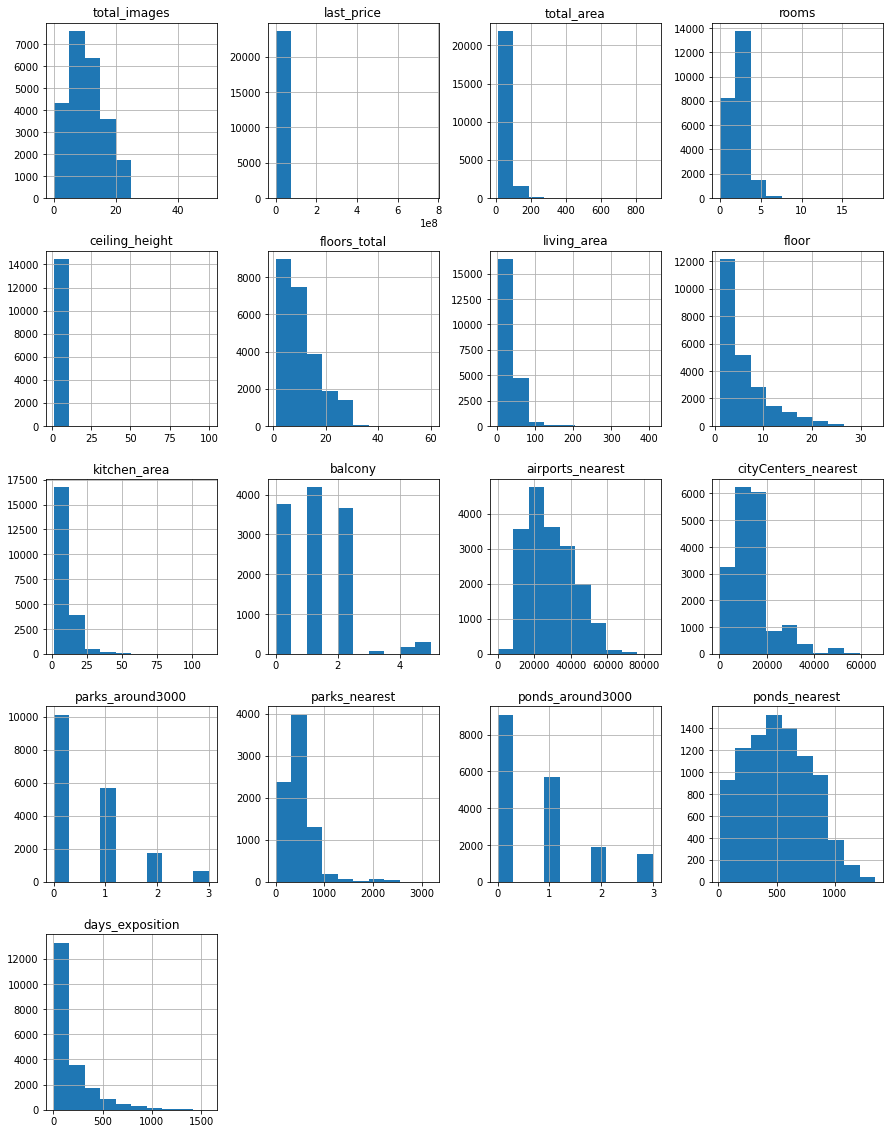

In [4]:
data.hist(figsize=(15, 20)); # построим диаграммы для каждого количественного признака

In [5]:
# проверим данные каждой колонки по статистич. анализу и диаграммам, ниже укажем наблюдения по ним

_a = 'floors_total'
print(data[_a].head(15))
print(data[_a].describe())
print(data[_a].sort_values().unique())

0     16.0
1     11.0
2      5.0
3     14.0
4     14.0
5     12.0
6     26.0
7     24.0
8     27.0
9      9.0
10    12.0
11     5.0
12     5.0
13     5.0
14     6.0
Name: floors_total, dtype: float64
count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 33. 34. 35. 36. 37. 52. 60.
 nan]


- is_apartment булевое значение, если имеются пропуски, то предположительно можно считать, что квартира не является апартаментами, поэтому необходимо заменить на False
- total_area max= от 400 до 900 проверить - либо ошибка, либо выброс
- rooms проверить почему комнат 0, это студия, апартаменты или ошибка? Почему комнат от 8 до 19 - ошибка или выброс?
- ceiling_height - min от 1 до 2.2, max=от 25 до 100, проверить, что это за данные и в каком кол-ве
- floors_total Перевести в int
- living_area - есть выбрасы от 200 до 400, судя по гистограмме
- kitchen_area выбросы от 40 до 112
- balcony в int
- airports_nearest - значение 0 ошибочное, заменить, удалить или заменить все пропуски 0
- parks_nearest/ponds_nearest - перенести данные с parks_around3000/ponds_around3000, данные об удаленности в пределах 3000м могут перекрыть большую часть пропусков, остальные пропуски замениь на 0
- days_exposition - имеются пропуски, скорее всего это квартиры, которые еще на продаже. Также имеются предложения с долгим периодом реализации (от 3 до 4 лет). 
- проверить, может после удаления очевидных выбросов, эти данные уйдут также

Вывод:
После первичного изучения наблюдаются большое количество пропусков, которые появились в ходе неполного заполнения данных пользователем и сложности автоматизации картографических данных, имеются большие отклонения от средних данных, что может говорить об ошибке в данных или выбросах, также в данных наблюдаются ошибки при заполнении,например, высота потолков в некоторых случаях наблюдается 25м, скорее всего должно быть 2.5м.
План дальнейших действий: исправляем ошибки, заполняем очевидные пропуски, убираем выбросы, удаляем дубликаты  и неявные дубликаты, заполняем пропущеные значения, удаляем пропуски, изменяем тип данных, где неоходимо.

### Предобработка данных

In [6]:
#заменим тип данных в дате на более читабельный

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [7]:
#заменим пропуски в апартаментах. Логично предположить, если ничего не указано, то это не апартаменты, т.е заменим пропуски на False

data['is_apartment'].value_counts()
data.loc[data['is_apartment']!=True, 'is_apartment'] = False
data['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

In [8]:
# проверим квартиры с комнатами = 0 (193 шт). Где больше встречается комнат =0 в студии, апартаментах, открытой планировке?
data['rooms'].value_counts()
room_0 = data.loc[data['rooms']==0]
print(room_0['studio'].value_counts())

#print(room_0['is_apartment'].value_counts())
#print(room_0['open_plan'].value_counts())
#print(len(room_0))

#studio = data.loc[data['studio']==True]
#print(studio['studio'].value_counts())

print(room_0['open_plan'].value_counts())


#всего 197 комнат=0, из них 138 - это студии, 59 - это открытая планировка. Похоже на правду

True     138
False     59
Name: studio, dtype: int64
False    138
True      59
Name: open_plan, dtype: int64


In [9]:
#заменим данные в высоте потолков. Отфильтруем самые низкие и высокие потолки

data.loc[data['ceiling_height'] < 2] #3 строки из всего датасета, можно оставить ради других данных для анализа
height_12=data.loc[data['ceiling_height'] >= 24] #21 строка не так много, но все-таки исправим, скорее всего при заполнении анкеты не посталили разделитель десятизначного значение и 24 должно быть 2.4

for i in height_12.index:
    if i == data.index[i]:
        data['ceiling_height'][i] = data['ceiling_height'][i] / 10
        
# для проверки выводим снова таблицу с данными выше 24 м. Ничего не находит.
#height_12

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [10]:
#в колонке Балкон имеются пропуски. Если ничего не указано, логично предположить, что их и нет, поэтому заменим пропуски на 0
data['balcony'] = data['balcony'].fillna(0)

# проверим остались ли пропуски в колонке балкон. 
data[data['balcony'].isna()].head()

#Пропусков нет

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [11]:
#заменим все неявные дубликаты, связанные с написанием населенного пункта

data['locality_name'] = data['locality_name'].replace('поселок', 'посёлок',regex=True).replace('посёлок городского типа', 'посёлок',regex=True)
data['locality_name'] = data['locality_name'].fillna('неизвестный')
data['locality_name'].sort_values().unique()


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Виллози', 'городской посёлок Лесогорский',
       'городской посёлок Мга', 'городской посёлок Назия',
       'городской посёлок Новоселье', 'городской посёлок Павлово',
       'городской посёлок Рощино', 'городской посёлок Свирьстрой',
       'городской посёлок Советский', 'городской посёлок Фёд

In [12]:
# найдем дубликаты
data[data.duplicated()].head()

# дубликатов нет

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [13]:
# заполним оставшиеся пробелы в потолках медианным значением стандартных высот по региону, сгруппировав данные по населенному пункту.
# в итоге заполнили медианным значением с 14504 до 23543 позиций
ceiling_height = data[data['ceiling_height'] <= 5]
median_ceiling = data.groupby('locality_name')['ceiling_height'].transform('median')
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling)

# оставшиеся пустые значения 156 шт удаляем для чистоты анализа (это меньше 1%). В итоге остается 23543 значения
data=data.dropna(subset=['ceiling_height'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23593 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23593 non-null  int64         
 1   last_price            23593 non-null  float64       
 2   total_area            23593 non-null  float64       
 3   first_day_exposition  23593 non-null  datetime64[ns]
 4   rooms                 23593 non-null  int64         
 5   ceiling_height        23593 non-null  float64       
 6   floors_total          23507 non-null  float64       
 7   living_area           21713 non-null  float64       
 8   floor                 23593 non-null  int64         
 9   is_apartment          23593 non-null  object        
 10  studio                23593 non-null  bool          
 11  open_plan             23593 non-null  bool          
 12  kitchen_area          21342 non-null  float64       
 13  balcony         

In [14]:
# в высоте потолков большой разброс нетипичных высот. Насчитывается небольшая группа больше 5 метров, скорее всего это нежилые площади, поэтому удалим их для чистоты анализа
# Удалим их. Остается 23577
data = data[(data['ceiling_height'] <= 5)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23577 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23577 non-null  int64         
 1   last_price            23577 non-null  float64       
 2   total_area            23577 non-null  float64       
 3   first_day_exposition  23577 non-null  datetime64[ns]
 4   rooms                 23577 non-null  int64         
 5   ceiling_height        23577 non-null  float64       
 6   floors_total          23491 non-null  float64       
 7   living_area           21699 non-null  float64       
 8   floor                 23577 non-null  int64         
 9   is_apartment          23577 non-null  object        
 10  studio                23577 non-null  bool          
 11  open_plan             23577 non-null  bool          
 12  kitchen_area          21331 non-null  float64       
 13  balcony         

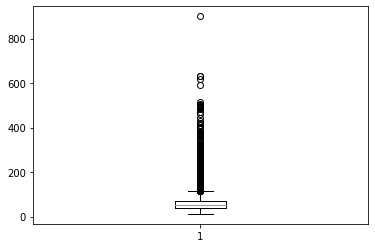

In [15]:
# в площади наблюдаются выбрасы со 100м. Для начала удалим выбросы с 150м/
# Из 23577 осталось 22999 позиций
plt.boxplot(data['total_area'])
data = data[(data['total_area'] < 150)]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f54af58db80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f54af59b280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f54af58d820>],
 'medians': [<matplotlib.lines.Line2D at 0x7f54af59b940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f54af59bca0>],
 'means': []}

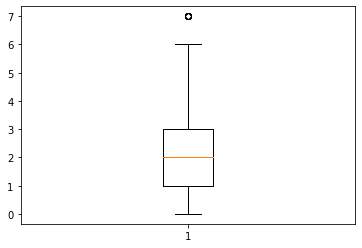

In [16]:
# удаляем выбросы в комнатах. В датасете имеются нетипичные многокомнатные квартиры, их немного, но они могут повлиять на чистоту анализа

plt.boxplot(data['rooms'])

#боксплот подтвердил диаграмму и указал, что больше 6 комнат это выброс


In [17]:
# удалим квартиры с комнатами более 6
data = data[(data['rooms'] <= 6)]

data.info()
# осталось 22991

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22991 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22991 non-null  int64         
 1   last_price            22991 non-null  float64       
 2   total_area            22991 non-null  float64       
 3   first_day_exposition  22991 non-null  datetime64[ns]
 4   rooms                 22991 non-null  int64         
 5   ceiling_height        22991 non-null  float64       
 6   floors_total          22906 non-null  float64       
 7   living_area           21183 non-null  float64       
 8   floor                 22991 non-null  int64         
 9   is_apartment          22991 non-null  object        
 10  studio                22991 non-null  bool          
 11  open_plan             22991 non-null  bool          
 12  kitchen_area          20814 non-null  float64       
 13  balcony         

In [18]:
# floors_total - имеется около 100 пропусков. Заменим их медианным значением, сгруппированных данных по населенному пункту

median_floors_total = data.groupby('locality_name')['floors_total'].transform('median')
data['floors_total'] = data['floors_total'].fillna(median_floors_total)

# Произведем проверку медианных значений, не превышает ли медиана номер этажа, на котором находится квартира
cheek_floor = data.loc[data['floors_total'] < data['floor']]
cheek_floor
# их оказалось всего 4. Удалим из анализа
data = data.drop(index=[8478])
data = data.drop(index=[10058])
data = data.drop(index=[14264])
data = data.drop(index=[21651])

data.info() # итого 14068позиций

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22987 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22987 non-null  int64         
 1   last_price            22987 non-null  float64       
 2   total_area            22987 non-null  float64       
 3   first_day_exposition  22987 non-null  datetime64[ns]
 4   rooms                 22987 non-null  int64         
 5   ceiling_height        22987 non-null  float64       
 6   floors_total          22987 non-null  float64       
 7   living_area           21179 non-null  float64       
 8   floor                 22987 non-null  int64         
 9   is_apartment          22987 non-null  object        
 10  studio                22987 non-null  bool          
 11  open_plan             22987 non-null  bool          
 12  kitchen_area          20811 non-null  float64       
 13  balcony         

In [19]:
# заполним медианным значением удаленность от аэропорта, сгруппировав данные по населенному пункту. Дополнили данные с 17572 до 18236
median_airport = data.groupby('locality_name')['airports_nearest'].transform('median')
data['airports_nearest'] = data['airports_nearest'].fillna(median_airport)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22987 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22987 non-null  int64         
 1   last_price            22987 non-null  float64       
 2   total_area            22987 non-null  float64       
 3   first_day_exposition  22987 non-null  datetime64[ns]
 4   rooms                 22987 non-null  int64         
 5   ceiling_height        22987 non-null  float64       
 6   floors_total          22987 non-null  float64       
 7   living_area           21179 non-null  float64       
 8   floor                 22987 non-null  int64         
 9   is_apartment          22987 non-null  object        
 10  studio                22987 non-null  bool          
 11  open_plan             22987 non-null  bool          
 12  kitchen_area          20811 non-null  float64       
 13  balcony         

In [20]:
# пробелы последних 7 колонок датасета с картографией и количеством дней размещения объявления
# Пропусков очень много, удалять нельзя, поэтому заменим на 0.
# И при дальнейшем анализе этих колонок необходимо производить фильтрацию датасета и исключать нулевые значеия из анализа, чтоб они не повлияли на результат
_list_ = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']

for name in _list_:
    data[name] = data[name].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22987 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22987 non-null  int64         
 1   last_price            22987 non-null  float64       
 2   total_area            22987 non-null  float64       
 3   first_day_exposition  22987 non-null  datetime64[ns]
 4   rooms                 22987 non-null  int64         
 5   ceiling_height        22987 non-null  float64       
 6   floors_total          22987 non-null  float64       
 7   living_area           21179 non-null  float64       
 8   floor                 22987 non-null  int64         
 9   is_apartment          22987 non-null  object        
 10  studio                22987 non-null  bool          
 11  open_plan             22987 non-null  bool          
 12  kitchen_area          20811 non-null  float64       
 13  balcony         

In [21]:
# последние пропуски в 2х колонках living_area и kitchen_area. Всего пропусков 2595, больше 10% от всех данных
# удалять нельзя, чтоб не потерять данные для анализа, поэтому заменим данные средним медианным значением по региону

data.loc[data.isna().any(axis=1)]

median_living_area = data.groupby('locality_name')['living_area'].transform('median')
data['living_area'] = data['living_area'].fillna(median_living_area)

median_kitchen_area = data.groupby('locality_name')['kitchen_area'].transform('median')
data['kitchen_area'] = data['kitchen_area'].fillna(median_kitchen_area)

In [22]:
# проверим, остались ли пропуски в  living_area и kitchen_area

#data.isna().any() - остались пропуски. Удалим их, т.к. их немного (не больше 10 позиций)

data = data.dropna(subset=['kitchen_area', 'living_area'])
data.isna().any()

total_images            False
last_price              False
total_area              False
first_day_exposition    False
rooms                   False
ceiling_height          False
floors_total            False
living_area             False
floor                   False
is_apartment            False
studio                  False
open_plan               False
kitchen_area            False
balcony                 False
locality_name           False
airports_nearest        False
cityCenters_nearest     False
parks_around3000        False
parks_nearest           False
ponds_around3000        False
ponds_nearest           False
days_exposition         False
dtype: bool

In [23]:
# еще раз взглянем на данные таблицы

#  data.info() необходимо заменить формат данных в колонках балкон, этажность дома, кол-во дней на целые числа для легкого восприятия информации

# is_apartment переводим в булевое значение, чтоб можно было проводить анализ данных

data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22981 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22981 non-null  int64         
 1   last_price            22981 non-null  float64       
 2   total_area            22981 non-null  float64       
 3   first_day_exposition  22981 non-null  datetime64[ns]
 4   rooms                 22981 non-null  int64         
 5   ceiling_height        22981 non-null  float64       
 6   floors_total          22981 non-null  int64         
 7   living_area           22981 non-null  float64       
 8   floor                 22981 non-null  int64         
 9   is_apartment          22981 non-null  bool          
 10  studio                22981 non-null  bool          
 11  open_plan             22981 non-null  bool          
 12  kitchen_area          22981 non-null  float64       
 13  balcony         

Вывод по предобработке данных:
- В данных было много пропусков, некоторые появились в ходе незаполнения данных потребителем, некоторые образовались из-за несовершенства автоматизации с картографическими данными.
- Часть пропусков была заполнена исходя из логики, как например отсутствие балкона или принадлежность квартиры к апартаментам и т.д
- Были удалены выбросы и незначительные пропуски в данных. В итоге из 23699 позиций к анализу готовы 22985 позиций (удалено было всего 714 значения, это 3% от изначальных данных)
- Пропуски, после удаления всех выбросов, были заменены медианным значением, свойственным населенному пункту. Самый большой пробел в данных был у ceiling_height (приблизительно 40%), но замена на медианное значение не должна сильно сказаться на результат, так как высота потолков, как правило, не выходит за стандарты. Самые важные замены пропусков были сделаны living_area и kitchen_area, но общие замены не достигает и 10% от всех данных, поэтому и в этом случае замена на медиану была допустима.


In [24]:
data['price_sq_met'] = round(data['last_price'] / data['total_area'],2) # стоимость за 1 кв.м (руб)
data['weekday'] = data['first_day_exposition'].dt.weekday # день недели (понедельник - 0, вторник - 1 и тд)
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month # месяц
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year # год

# функция и цикл для создания новой колонки 'type_floor', где тип1 - это 1 этаж, тип 2  - другой, тип 3 - последний

def floot(number):
    if number == 1:
        return 1
    else:
        return 2
data['type_floor'] = data['floor'].apply(floot)

for i in data.index:
    if data['floor'][i] == data['floors_total'][i]:
            data['type_floor'][i] = 3
            
# новая колонка - расстояние до центра, переведенные в км 
data['distance_to_city'] = round(data['cityCenters_nearest'] / 1000, 0)
data['distance_to_city'] = data['distance_to_city'].astype('int')

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_met,weekday,month,year,type_floor,distance_to_city
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,...,16028.0,1.0,482.0,2.0,755.0,0,120370.37,3,3,2019,2,16
1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,False,False,False,...,18603.0,0.0,0.0,0.0,0.0,81,82920.79,1,12,2018,1,19
2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,False,False,...,13933.0,1.0,90.0,2.0,574.0,558,92785.71,3,8,2015,2,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,...,8098.0,2.0,112.0,1.0,48.0,121,100000.00,1,6,2018,2,8
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,...,0.0,0.0,0.0,0.0,0.0,55,95065.79,0,9,2018,2,0


### Проведем исследовательский анализ данных

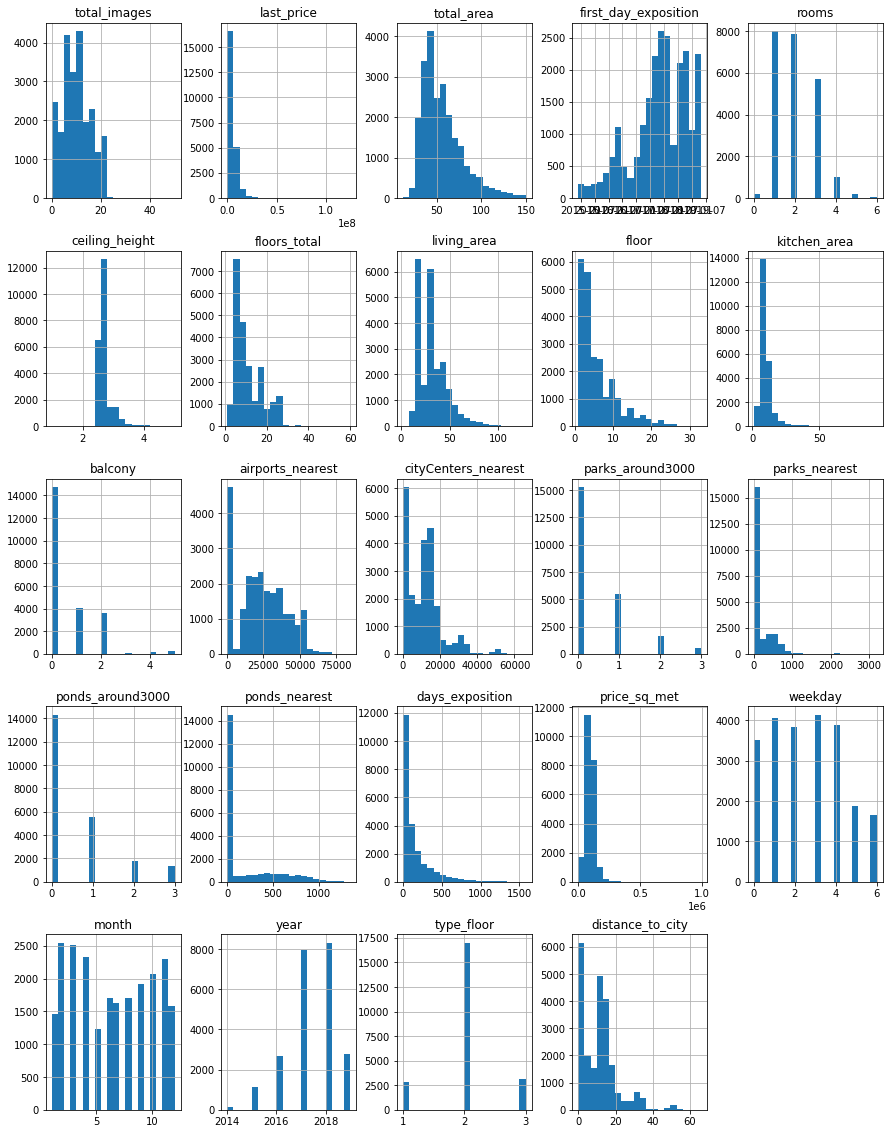

In [25]:
data.hist(bins=20, figsize=(15, 20)); # построим отдельные диаграммы для каждого количественного признака

In [26]:
# проверим данные каждой колонки по статистич. анализу и диаграммам, ниже укажем наблюдения по ним

_b = 'month'
print(data[_b].describe())
print(data[_b].sort_values().unique())

count    22981.000000
mean         6.401506
std          3.490409
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64
[ 1  2  3  4  5  6  7  8  9 10 11 12]


- total_area - общая площадь в основном от 40 до 60 кв.м
- living_area - жилая зона в основном от 18  до 40 кв.м
- kitchen_area - кухни в основном от 7 до 10кв.м
- last_price - все сделки свершались в диапазоне 3.5-6 млн
- rooms - в основном продают одно-, двухкомнатные квартиры (больше 50%), потом меньше 3-хкомнатные квартиры
- ceiling_height - в основном высоты потолков до 2.5-3 м
- floor - основная масса квартир до 10 этажа, но большая часть до 5 этажа
- type_floor - в меньшей степени 1 и последние этажи, основная масса - это другие этажи
- floors_total - больше половины квартир до 9-этажного дома, меньше четверти в пределах 16-этажного здания
- airports_nearest - большая часть квартир находится на расстоянии 20-30 км от аэропорта
- cityCenters_nearest - основная часть квартир находится на расстоянии 12-15км от центра, только четверт квартир находится на расстоянии 2 км от центра
- parks_nearest - только у четверти квартир имеется парк вблизи 
- weekday - в основном сделки заключались в будние дни
- month - в основном сделки совершались с серидины января по мая и с сентября по ноябрь. Летом и в праздничный период сделки в меньшем количестве.

count    19980.000000
mean       178.460060
std        217.336828
min          1.000000
25%         44.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

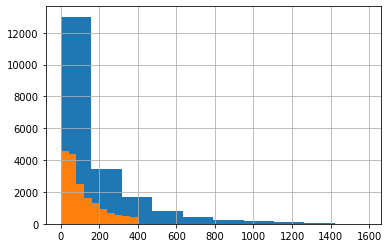

In [27]:
# рассмотрим days_exposition, но прежде уберем из анализа данные с нулевым показателем, т.к. ранее все пропуски были изменены на 0

data_data_exposition_wo_0 = data.loc[data['days_exposition'] != 0]
data_data_exposition_wo_0['days_exposition'].hist()
data_data_exposition_wo_0['days_exposition'].hist(range=(1,400))
data_data_exposition_wo_0['days_exposition'].describe()

# большая половина квартир из закрытых сделок, а их 19981, были сняты с продажи в течение 100 дней (3 месяца), 
# вторая половина сделок закрывалась в течение 200-250 дней, небольшой процент сделок был закрыт в течение 1000-1500дней (это 3-4 года)
# Быстрыми продажами будем считать уровень 25% сделок, а именно  до 30 дней (до 1 месяца)
# Средними продажами  - 31-95 дней (1-3 месяца)
# Долгими продажами - от 96 до 200 (3-6 месяцев) и все свыше 200 дней - необычно долгими


<AxesSubplot:>

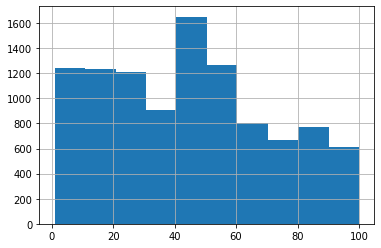

In [28]:
# проверим диапазон от 0 до 100.
# наблюдается 2 пика активности, скорее всего связанных с тем, что на квартиры имеется спрос и многие потребители понимают какой тип квартир им необходим. 
# Первый пик определяется в течение 2-3 недель с покупкой, 2 пик - в течении 1.4-2 месяцев.

data_data_exposition_wo_0['days_exposition'].hist(range=(1,100))

In [29]:
# Посмотрим как долго продавались квартиры в зависимости от кол-ва комнат
data.groupby('rooms').agg({'days_exposition': ['count', 'mean']})

# наблюдается прямая зависимость, чем меньше комнат, тем быстрее продаются квартиры

days_exposition            
                count        mean
rooms                            
0                 193  101.891192
1                8006  144.063827
2                7874  151.053340
3                5695  168.978753
4                1017  195.614553
5                 174  211.436782
6                  22  233.363636

In [30]:
# проверим имеется ли зависимости срока продажи от типа этажа.
data.groupby('type_floor').agg({'days_exposition': ['count', 'mean']})

# дольше всех продаются квартиры на 1 этаже, но разница с остальными небольшая. 
# Быстрее продаются квартиры из категории ДРУГИЕ, т..е не на первом и последнием этажах

days_exposition            
                     count        mean
type_floor                            
1                     2821  171.896491
2                    16990  151.393467
3                     3170  160.421767

In [31]:
data.groupby('total_images').agg({'days_exposition': ['count', 'mean']})

# наличие фото неявно, но влияют на быстроту сделки. Именно у быстрых сделок наблюдается наличие фото

days_exposition            
                       count        mean
total_images                            
0                       1035  136.610628
1                        828  183.086957
2                        615  191.198374
3                        739  179.238160
4                        961  177.073881
5                       1268  170.583596
6                       1446  174.359613
7                       1483  163.780175
8                       1544  158.527850
9                       1695  149.085546
10                      1764  159.772109
11                      1337  147.559461
12                      1201  153.120733
13                       992  150.633065
14                       954  147.540881
15                       921  141.198697
16                       741  132.024291
17                       628  135.342357
18                       618  135.135922
19                       564  125.411348
20                      1577  136.845910
21                        12  103.833333
22                         8  161.000000
23                        15  100.400000
24                         8  149.000000
26                         4   50.500000
27                         2   97.000000
28                         3  145.333333
29                         3  103.666667
30                         2   42.500000
31                         2   71.000000
32                         3  129.666667
35                         2   41.000000
37                         1   64.000000
39                         1  106.000000
42                         1  172.000000
50                         3   38.000000

In [32]:
# проверим влияние размера кухни на быстроту продажи
kitchen = data.groupby('kitchen_area').agg({'days_exposition': ['count', 'mean']})
kitchen.columns = ['count', 'mean']
kitchen = kitchen.loc[kitchen['mean'] != 0]
kitchen.sort_values(by='mean').head()


# явной закономерности не прослеживается быстро продаются квартиры как с большой, так и  маленькой кухнями

,count,mean
kitchen_area,,
13.26,2,3.0
64.00,2,3.5
5.04,1,4.0
6.73,1,4.0
8.18,1,4.0


0.6960999803183319
0.5437598591308528
0.5267691600047733


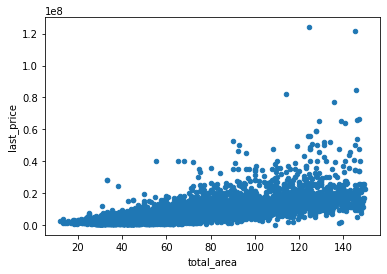

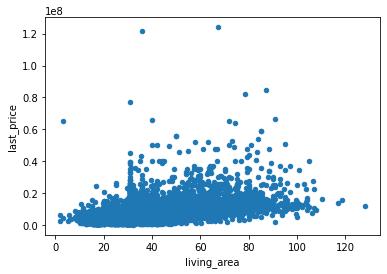

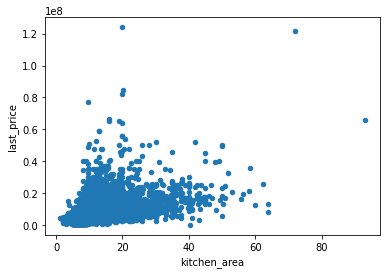

In [33]:
# проверим что влияет на стоимость квартиры c помощью коэффициента корреляции 
# и построим диаграмму рассеивания для анализа зависимости

corr_price = ['total_area', 'living_area', 'kitchen_area']

for name in corr_price:
    print(data['last_price'].corr(data[name]))
    data.plot(x=name, y='last_price', kind='scatter')

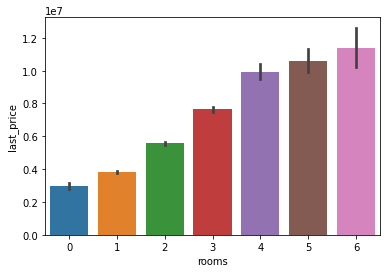

In [34]:
#наблюдаем прямую зависимость  цены от кол-ва комнат. Чем больше комнат, тем больше цена. Это логично
#заметим, что ценовой диапозон многокомнатных квартир как 4, 5, 6-тикомнатных квартир не сильно отличается по цене друг от друга
sns.barplot(x=data['rooms'], y=data['last_price']);



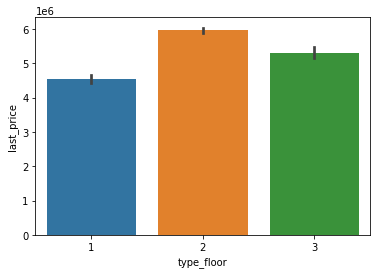

In [35]:
# больше покупают квартиры не на первом и последнем этажах
sns.barplot(x=data['type_floor'], y=data['last_price']);

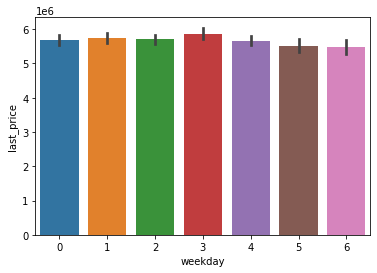

In [36]:
# не наблюдается никакой зависимости общей цены от дня закрытия объявления
sns.barplot(x=data['weekday'], y=data['last_price']);

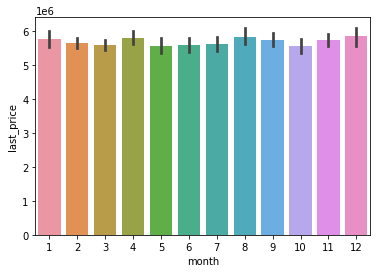

In [37]:
# не наблюдается никакой зависимости общей стоимости от месяца сделки
sns.barplot(x=data['month'], y=data['last_price']);

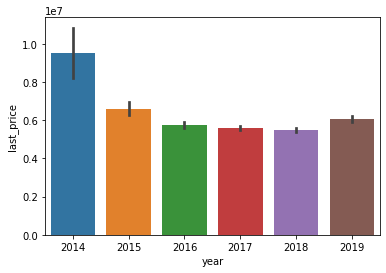

In [38]:
# с 2014 года резко упали продажи квартир, возможно это связно с нестабильностью экономики России из-за санкций
sns.barplot(x=data['year'], y=data['last_price']);

Выводы по коэффициенту корреляции и диаграмме рассеивания
- 'total_area' - наблюдается прямая зависимость общей цены от площади квартиру. Диаграмма и корреляция показали что, чем больше площадь, тем больше стоимость за квартиру
- 'living_area' - наблюдается не ярко выраженная прямая зависимость общей цены от жилой площади квартиру. Диаграмма и корреляция показали что, чем больше жилой плошади, тем больше стоимость за квартиру.
- 'kitchen_area' - наблюдается не ярко выраженная прямая зависимость общей цены от площади кухни. Диаграмма и корреляция показали что, чем больше плошадь кухни, тем больше стоимость за квартиру
- 'rooms' - наблюдается прямая зависимость общей цены от количества комнат в квартире. Но судя по диаграмме данная зависимость наблюдается до 3-хкомнатных квартир. Стоимость 4-х, 5-ти и 6-тикомнатные квартиры приблизительно в одной ценовой позиции.
- 'type_floor' - в основном  покупают квартиры не на первом и последним этажах
- 'weekday' - не наблюдается никакой зависимости общей цены от дня закрытия объявления
- 'month' - не наблюдается никакой зависимости общей стоимости от месяца сделки. +/- количество снятых объявлений везде одинаковое
- 'year' - с 2014 года резко упали продажи квартир, возможно это связно с нестабильностью экономики России из-за санкций

In [39]:
# выведем топ 10 населенных пунктов по кол-ву объявлений и укажем среднюю стоимость за кв метр по населенному пункту
local_top_10 = data.groupby('locality_name'). agg({'price_sq_met': ['count', 'mean']})

local_top_10.columns = ['count', 'mean']
local_top_10 = local_top_10.sort_values(by='count', ascending = False)[0:10]
local_top_10

# лидером по кол-ву объявлений является крупный город Санкт-Петербург (около 70% всех обьявлений) и средняя стоимость за 1 кв.м у него так же самая высокая
# далее из полученной таблицы сделать какие-то определенные выводы нельзя, 
# т.к. не наблюдается никакой закономерности между кол-ом объявлений и стоимостью за кв.м

,count,mean
locality_name,,
Санкт-Петербург,15155,112235.804073
посёлок Мурино,556,85681.762572
посёлок Шушары,439,78551.344647
Всеволожск,397,68703.119723
Пушкин,359,102866.519694
Колпино,337,75333.295816
посёлок Парголово,326,90332.262638
Гатчина,307,68746.146515
деревня Кудрово,299,92473.547559


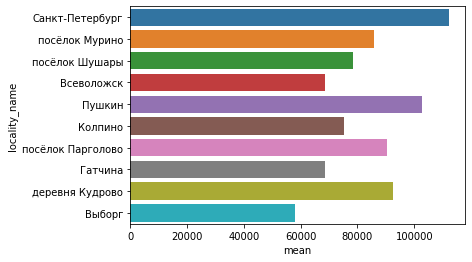

In [40]:
sns.barplot(x=local_top_10['mean'], y=local_top_10.index);

In [41]:
# выведем данные по Питеру и сравним, влияет ли удаленность от центра на стоимость квартиры и вычислим сред.стоимость одного км
# но для начала удалим все данные с нулевым значением в distance_to_city, ранее мы заполняли NaN занчением 0 (в Питере их около 50позиций)

location_center_Piter = data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['distance_to_city'] != 0)]

location_center_Piter['price_for_km'] = location_center_Piter['last_price'] / location_center_Piter['distance_to_city']
mean_price_for_km = location_center_Piter.groupby('distance_to_city')['price_for_km'].mean()
mean_price_for_km

# Наблюдается закономерность уменьшения цены за кв. м при увеличении километража, но она не явная, 
# т..к имеется разброс цен в каждой анализируемой группе, потому что сравниваются неодинаковые квартиры, а различные (разная площадь,  кол-во комнат и т.д) 

distance_to_city
1     1.164025e+07
2     6.001206e+06
3     3.176086e+06
4     2.468926e+06
5     2.093228e+06
6     1.811446e+06
7     1.651567e+06
8     1.028508e+06
9     7.524207e+05
10    6.199244e+05
11    5.485521e+05
12    4.788863e+05
13    4.592296e+05
14    3.958878e+05
15    3.803656e+05
16    3.306974e+05
17    3.035989e+05
18    2.649330e+05
19    2.651408e+05
20    2.975732e+05
21    2.615938e+05
22    2.415745e+05
23    2.039062e+05
24    1.606012e+05
25    1.621136e+05
26    1.528082e+05
27    3.074074e+05
28    1.795153e+05
29    1.460920e+05
Name: price_for_km, dtype: float64

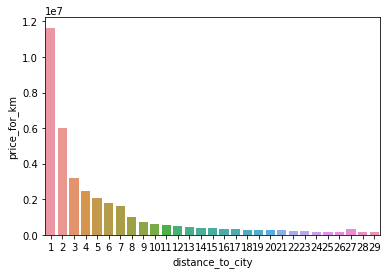

In [42]:
# судя по графику центр города заканчивается на 8 км
sns.barplot(x=mean_price_for_km.index, y=mean_price_for_km);

### Общий вывод

ВЫВОД проведенного анализа

В предоставленных данных были ошибки и пропуски. Ошибки были исправлены (это не больше 1% данных), пропуски были заменены медианным значением по группе населенного пункта (не больше 10% данных), выбросы были удалены. К анализу был подготовлен датасет с данными, сокращенный всего на 3% от первоначальных данных.

Основной объем объявлений по продаже квартир составляет город-многомиллионник Санкт-Петербург (около 70% всех объявлений).
Как один из крупных кородов России Питер имеет самую высокую стоимость за кв.м среди изучаемых населенных пунктов. 
Большая половина квартир продается в течение 3-х месяцев, самые быстрые сделки совершаются в пределах 20-30 дней.
На стоимость квартиры влияет несколько признаков:
- чем больше площадь квартиры (соот-но кол-во комнат, жилая площадь и площадь кухни), тем дороже стоимость квартиры.
- чем ближе квартира к центру, тем стоимость больше (построенный график распределения общей цены помог определить, что центр оканчивается на 8 км, после этого рубежа разница в стоимости квартир небольшая.

Проведенный анализ позволил обнаружить некоторые закономерности, которые влияют на быстроту сделки:
- чем меньше количество комнат (соответсвенно и общая площадь), тем быстрее продаются квартиры, т.е студии и однокомнатные, а затем двухкомнатные более востребованны рынком недвижимости. Возможно это связано с тем, что данные квартиры более доступны для большинства населения.
- этаж также оказывает влияние на быстроту сделки. Быстрее продаются квартиры, которые находятся не на первом и последнем этажах.
- наличие фото также способствует ускорению процесса продажи

Также удалось выявить особенность рынка недвижимости:
- с 2014 года резко упали продажи квартир, возможно это связно с нестабильностью в экономике России из-за санкций
- ценовой диапозон многокомнатных квартир, как 4, 5, 6-тикомнатных квартир, не сильно отличается по цене друг от друга. То есть на рубеже с 4-хкомнатной квартиры зависимость цены от общей площади резко снижается. Скорее всего это связано с востребованностью квартир меньшей площадью у большинства населения.
